# Gravix Layer Cookbook: Stock Analysis using LangChain Orchestration
This notebook provides a step-by-step guide to building a complete **Agentic Stock Analysis** workflow using the **Gravix Layer** API, Yahoo Finance, NewsAPI, and LangChain. You will learn how to create an application that analyzes stocks and generates insights using agentic orchestration and LLM-powered tools.

### What is Agentic Stock Analysis?
Agentic Stock Analysis uses a modular, tool-based approach to combine data retrieval, technical analysis, sentiment analysis, and LLM-powered reasoning. Instead of just relying on static data or a single model, the workflow orchestrates multiple agents and tools to deliver comprehensive, up-to-date insights.

### In this notebook, you will learn to:
1. **Set up** the environment and configure the Gravix Layer client.
2. **Fetch** and process stock data from Yahoo Finance.
3. **Analyze** news sentiment using NewsAPI and TextBlob.
4. **Visualize** stock trends and technical indicators.
5. **Orchestrate** agentic workflows with LangChain and Gravix Layer.
6. **Ask questions** and receive contextual, LLM-powered answers.

### Disclaimer
**This notebook is for informational and educational purposes only. Do not use the analysis or recommendations provided here as financial advice or for making trading decisions. The results are generated by automated tools and LLMs based on available data, and may contain errors or inaccuracies. Always consult a qualified financial advisor before making investment decisions.**

In [8]:
!pip install yfinance pandas matplotlib textblob gravixlayer langchain

In [9]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import requests
from datetime import datetime, timedelta
from gravixlayer import GravixLayer
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType

In [2]:
import os
GRAVIXLAYER_API_KEY = os.environ.get('GRAVIXLAYER_API_KEY')  # Get your API Key from platform.gravixlayer.com
NEWS_API_KEY = os.environ.get('NEWS_API_KEY')

In [ ]:
from gravixlayer import GravixLayer
from langchain.llms.base import LLM
from langchain.schema import Generation, LLMResult
from typing import Optional, List
import os

class GravixLayerLLM(LLM):
    def __init__(self, api_key: str, model: str = "meta-llama/llama-3.1-8b-instruct"):
        super().__init__()
        if not api_key:
            raise ValueError("GRAVIXLAYER_API_KEY is not set. Please set it in your environment or notebook.")
        self._api_key = api_key
        self._model = model
        self._client = GravixLayer(api_key=self._api_key)

    @property
    def _llm_type(self) -> str:
        return "gravixlayer"

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        response = self._client.chat.completions.create(
            model=self._model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=512,
            temperature=0.7
        )
        return response.choices[0].message.content.strip()

    def generate(self, prompts: List[str], stop: Optional[List[str]] = None, **kwargs) -> LLMResult:
        generations = []
        for prompt in prompts:
            text = self._call(prompt, stop=stop)
            generations.append([Generation(text=text)])
        return LLMResult(generations=generations)

llm = GravixLayerLLM(api_key=os.environ.get("GRAVIXLAYER_API_KEY"), model="meta-llama/llama-3.1-8b-instruct")

In [215]:
def fetch_stock_data_tool(ticker: str, period: str = "6mo") -> pd.DataFrame:
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    return df

def get_company_name_tool(ticker: str) -> str:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return info.get('longName', ticker)
    except:
        return ticker

def add_technical_indicators_tool(df: pd.DataFrame) -> pd.DataFrame:
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['Return'] = df['Close'].pct_change()
    df['Trend'] = df.apply(lambda row: 'Bullish' if row['SMA_20'] > row['SMA_50'] else 'Bearish', axis=1)
    return df

NEWS_API_KEY = os.environ.get("NEWS_API_KEY")
NEWS_API_URL = "https://newsapi.org/v2/everything"

def fetch_news_tool(ticker: str, company_name: str, days: int = 7) -> list:
    if not NEWS_API_KEY:
        return [
            f"{company_name} reports record quarterly earnings beating expectations",
            f"{company_name} faces regulatory scrutiny in Europe over App Store policies",
            f"Analysts predict strong growth in {company_name} services revenue"
        ]
    to_date = datetime.now()
    from_date = to_date - timedelta(days=days)
    params = {
        'q': f'{company_name} OR {ticker}',
        'from': from_date.strftime('%Y-%m-%d'),
        'to': to_date.strftime('%Y-%m-%d'),
        'sortBy': 'relevancy',
        'pageSize': 20,
        'language': 'en',
        'apiKey': NEWS_API_KEY
    }
    try:
        response = requests.get(NEWS_API_URL, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        articles = data.get('articles', [])
        news_texts = []
        for article in articles:
            title = article.get('title', '')
            description = article.get('description', '')
            if title:
                news_texts.append(title)
            if description and description != title:
                news_texts.append(description)
        news_texts = [text for text in news_texts if text and len(text) > 10][:15]
        if not news_texts:
            return [
                f"{company_name} reports quarterly earnings",
                f"{company_name} stock analysis by analysts",
                f"Market outlook for {company_name}"
            ]
        return news_texts
    except Exception:
        return [
            f"{company_name} reports quarterly earnings",
            f"{company_name} stock analysis by analysts",
            f"Market outlook for {company_name}"
        ]

def analyze_news_sentiment_tool(news_list: list) -> float:
    if not news_list:
        return 0
    sentiments = []
    for news in news_list:
        try:
            sentiment = TextBlob(str(news)).sentiment.polarity
            sentiments.append(sentiment)
        except:
            continue
    return sum(sentiments) / len(sentiments) if sentiments else 0

def plot_stock_tool(df: pd.DataFrame, ticker: str, sentiment_data: dict = None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    ax1.plot(df.index, df['Close'], label='Close Price', linewidth=2, color='black')
    ax1.plot(df.index, df['SMA_20'], label='SMA 20', alpha=0.7, color='blue')
    ax1.plot(df.index, df['SMA_50'], label='SMA 50', alpha=0.7, color='red')
    ax1.plot(df.index, df['EMA_20'], label='EMA 20', alpha=0.7, color='green')
    ax1.set_title(f"{ticker} Stock Price & Technical Indicators", fontsize=16, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax2.bar(df.index, df['Volume'], alpha=0.6, color='orange')
    ax2.set_title(f"{ticker} Trading Volume", fontsize=14)
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    if sentiment_data:
        sentiment_color = 'green' if sentiment_data['score'] > 0 else 'red' if sentiment_data['score'] < 0 else 'gray'
        fig.suptitle(f"News Sentiment: {sentiment_data['label']} ({sentiment_data['score']:.3f})", fontsize=12, color=sentiment_color, y=0.02)
    plt.tight_layout()
    plt.show()

In [216]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

def stock_analysis_workflow_langchain(ticker):
    company_name = get_company_name_tool(ticker)
    df = fetch_stock_data_tool(ticker)
    df = add_technical_indicators_tool(df)
    news_articles = fetch_news_tool(ticker, company_name)
    sentiment_score = analyze_news_sentiment_tool(news_articles)
    sentiment_data = {
        'score': sentiment_score,
        'label': 'Positive' if float(sentiment_score) > 0.1 else 'Negative' if float(sentiment_score) < -0.1 else 'Neutral',
        'articles': news_articles[:5] if isinstance(news_articles, list) else []
    }
    plot_stock_tool(df, ticker, sentiment_data)

    # Fetch as much info as possible from yfinance
    import yfinance as yf
    yf_ticker = yf.Ticker(ticker)
    info = yf_ticker.info if hasattr(yf_ticker, 'info') else {}
    open_price = info.get('open', df['Open'].iloc[-1] if 'Open' in df else None)
    high_price = info.get('dayHigh', df['High'].iloc[-1] if 'High' in df else None)
    low_price = info.get('dayLow', df['Low'].iloc[-1] if 'Low' in df else None)
    previous_close = info.get('previousClose', None)
    market_cap = info.get('marketCap', None)
    pe_ratio = info.get('trailingPE', None)
    forward_pe = info.get('forwardPE', None)
    dividend_yield = info.get('dividendYield', None)
    sector = info.get('sector', None)
    industry = info.get('industry', None)
    beta = info.get('beta', None)
    volume = info.get('volume', df['Volume'].iloc[-1] if 'Volume' in df else None)
    shares_outstanding = info.get('sharesOutstanding', None)
    earnings_date = info.get('earningsDate', None)
    fifty_two_week_high = info.get('fiftyTwoWeekHigh', None)
    fifty_two_week_low = info.get('fiftyTwoWeekLow', None)
    fifty_day_average = info.get('fiftyDayAverage', None)
    two_hundred_day_average = info.get('twoHundredDayAverage', None)
    # Additional technical and financial fields
    price_to_book = info.get('priceToBook', None)
    enterprise_value = info.get('enterpriseValue', None)
    trailing_eps = info.get('trailingEps', None)
    forward_eps = info.get('forwardEps', None)
    payout_ratio = info.get('payoutRatio', None)
    revenue = info.get('totalRevenue', None)
    gross_profits = info.get('grossProfits', None)
    operating_margin = info.get('operatingMargins', None)
    profit_margin = info.get('profitMargins', None)
    quick_ratio = info.get('quickRatio', None)
    current_ratio = info.get('currentRatio', None)
    debt_to_equity = info.get('debtToEquity', None)
    return_on_equity = info.get('returnOnEquity', None)
    return_on_assets = info.get('returnOnAssets', None)
    # More technical indicators from DataFrame
    sma_100 = df['Close'].rolling(100).mean().iloc[-1] if len(df) >= 100 else None
    sma_200 = df['Close'].rolling(200).mean().iloc[-1] if len(df) >= 200 else None
    ema_50 = df['Close'].ewm(span=50, adjust=False).mean().iloc[-1] if len(df) >= 50 else None
    ema_100 = df['Close'].ewm(span=100, adjust=False).mean().iloc[-1] if len(df) >= 100 else None

    prompt_template = PromptTemplate(
        input_variables=[
            "ticker", "company_name", "latest_close", "open_price", "high_price", "low_price", "previous_close", "market_cap", "pe_ratio", "forward_pe", "dividend_yield", "sector", "industry", "beta", "volume", "shares_outstanding", "earnings_date", "fifty_two_week_high", "fifty_two_week_low", "fifty_day_average", "two_hundred_day_average",
            "weekly_change", "monthly_change", "latest_volume", "sma_20", "sma_50", "ema_20", "trend", "volatility", "sentiment_score", "sentiment_label", "news_headlines",
            "price_to_book", "enterprise_value", "trailing_eps", "forward_eps", "payout_ratio", "revenue", "gross_profits", "operating_margin", "profit_margin", "quick_ratio", "current_ratio", "debt_to_equity", "return_on_equity", "return_on_assets",
            "sma_100", "sma_200", "ema_50", "ema_100"],
        template="""Comprehensive Stock Analysis Report for {ticker} ({company_name})\nPRICE DATA:\n- Current Price: ${latest_close:.2f}\n- Open Price: ${open_price}\n- High: ${high_price}\n- Low: ${low_price}\n- Previous Close: ${previous_close}\n- Market Cap: {market_cap}\n- PE Ratio: {pe_ratio}\n- Forward PE: {forward_pe}\n- Dividend Yield: {dividend_yield}\n- Sector: {sector}\n- Industry: {industry}\n- Beta: {beta}\n- Volume: {volume}\n- Shares Outstanding: {shares_outstanding}\n- Earnings Date: {earnings_date}\n- 52 Week High: {fifty_two_week_high}\n- 52 Week Low: {fifty_two_week_low}\n- 50 Day Avg: {fifty_day_average}\n- 200 Day Avg: {two_hundred_day_average}\n- Price to Book: {price_to_book}\n- Enterprise Value: {enterprise_value}\n- Trailing EPS: {trailing_eps}\n- Forward EPS: {forward_eps}\n- Payout Ratio: {payout_ratio}\n- Revenue: {revenue}\n- Gross Profits: {gross_profits}\n- Operating Margin: {operating_margin}\n- Profit Margin: {profit_margin}\n- Quick Ratio: {quick_ratio}\n- Current Ratio: {current_ratio}\n- Debt to Equity: {debt_to_equity}\n- Return on Equity: {return_on_equity}\n- Return on Assets: {return_on_assets}\n- Weekly Change: {weekly_change:.2f}%\n- Monthly Change: {monthly_change:.2f}%\n- Daily Volume: {latest_volume}\nTECHNICAL INDICATORS:\n- SMA 20: ${sma_20:.2f}\n- SMA 50: ${sma_50:.2f}\n- SMA 100: ${sma_100}\n- SMA 200: ${sma_200}\n- EMA 20: ${ema_20:.2f}\n- EMA 50: ${ema_50}\n- EMA 100: ${ema_100}\n- Current Trend: {trend}\n- Volatility (Daily): {volatility:.2f}%\nNEWS SENTIMENT:\n- Sentiment Score: {sentiment_score:.3f} ({sentiment_label})\n- Recent Headlines: {news_headlines}\nPlease provide a comprehensive analysis including:\n1. Technical Analysis Summary\n2. Sentiment Impact Assessment\n3. Risk Assessment\n4. Price Target and Time Horizon\n5. Investment Recommendation (Strong Buy/Buy/Hold/Sell/Strong Sell)\nFormat your response in a professional, structured manner."""
    )
    latest = df.iloc[-1]
    weekly_change = ((df['Close'].iloc[-1] - df['Close'].iloc[-5]) / df['Close'].iloc[-5]) * 100 if len(df) > 5 else 0
    monthly_change = ((df['Close'].iloc[-1] - df['Close'].iloc[-22]) / df['Close'].iloc[-22]) * 100 if len(df) > 22 else 0
    volatility = df['Return'].std() * 100 if 'Return' in df else 0
    llm_chain = LLMChain(llm=llm, prompt=prompt_template)
    inputs = {
        "ticker": ticker,
        "company_name": company_name,
        "latest_close": latest['Close'],
        "open_price": open_price,
        "high_price": high_price,
        "low_price": low_price,
        "previous_close": previous_close,
        "market_cap": market_cap,
        "pe_ratio": pe_ratio,
        "forward_pe": forward_pe,
        "dividend_yield": dividend_yield,
        "sector": sector,
        "industry": industry,
        "beta": beta,
        "volume": volume,
        "shares_outstanding": shares_outstanding,
        "earnings_date": earnings_date,
        "fifty_two_week_high": fifty_two_week_high,
        "fifty_two_week_low": fifty_two_week_low,
        "fifty_day_average": fifty_day_average,
        "two_hundred_day_average": two_hundred_day_average,
        "weekly_change": weekly_change,
        "monthly_change": monthly_change,
        "latest_volume": latest['Volume'],
        "sma_20": latest['SMA_20'],
        "sma_50": latest['SMA_50'],
        "ema_20": latest['EMA_20'],
        "trend": latest['Trend'],
        "volatility": volatility,
        "sentiment_score": sentiment_score,
        "sentiment_label": sentiment_data['label'],
        "news_headlines": '; '.join(sentiment_data['articles']),
        "price_to_book": price_to_book,
        "enterprise_value": enterprise_value,
        "trailing_eps": trailing_eps,
        "forward_eps": forward_eps,
        "payout_ratio": payout_ratio,
        "revenue": revenue,
        "gross_profits": gross_profits,
        "operating_margin": operating_margin,
        "profit_margin": profit_margin,
        "quick_ratio": quick_ratio,
        "current_ratio": current_ratio,
        "debt_to_equity": debt_to_equity,
        "return_on_equity": return_on_equity,
        "return_on_assets": return_on_assets,
        "sma_100": sma_100,
        "sma_200": sma_200,
        "ema_50": ema_50,
        "ema_100": ema_100
    }
    result = llm_chain.invoke(inputs)
    insights = result['text'] if 'text' in result else result
    print(insights)
    return {
        'data': df,
        'sentiment': sentiment_data,
        'analysis': insights
    }

> **Note:** The workflow currently pulls a comprehensive set of key financial metrics from yfinance for analysis. If you wish to use additional data fields, you can access them directly from the `yf.Ticker(ticker).info` dictionary and add them to the analysis or prompt as needed. yfinance provides a wide range of company and market data for further customization.

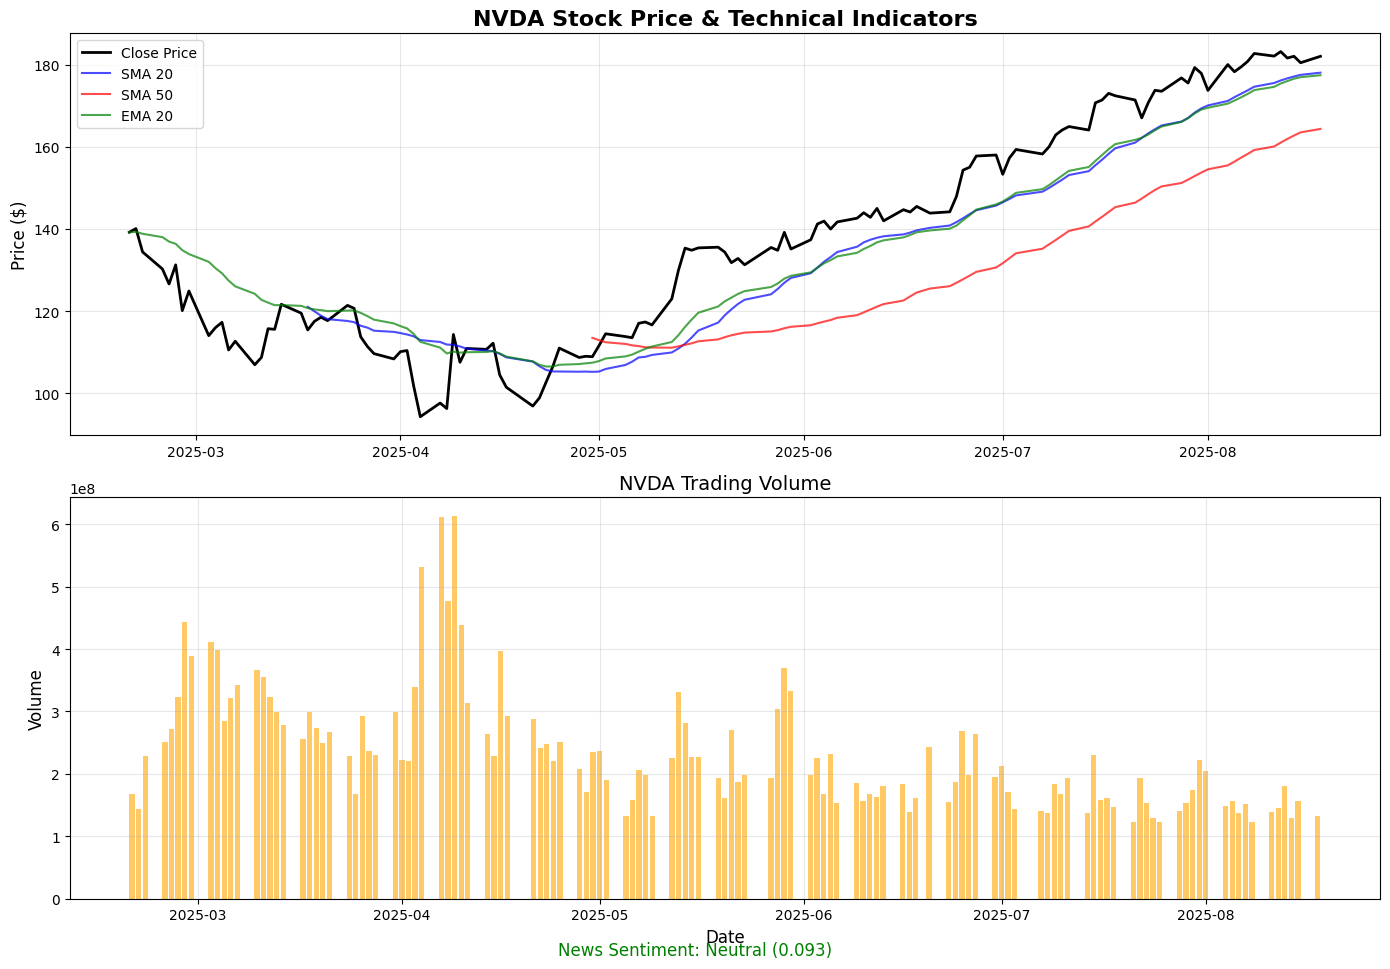

**Comprehensive Stock Analysis Report for NVDA (NVIDIA Corporation)**

**Introduction**

This report provides an in-depth analysis of NVIDIA Corporation's (NVDA) current market performance, technical indicators, news sentiment, and risk assessment. Our analysis will help investors make informed decisions regarding their investment in NVDA.

**Technical Analysis Summary**

NVDA's technical indicators suggest a bullish trend:

* **Current Trend:** Bullish
* **SMA 20:** $178.03 (above current price)
* **SMA 50:** $164.34 (above current price)
* **EMA 20:** $177.41 (above current price)
* **Volatility (Daily):** 3.32% (moderate)

The moving averages are trending upwards, indicating a strong upward momentum. However, the volatility is moderate, suggesting that the stock may experience some fluctuations.

**Sentiment Impact Assessment**

NVDA's news sentiment score is neutral:

* **Sentiment Score:** 0.093
* **Recent Headlines:**
	+ Quantum Stocks Q2 2025: Are D-Wave, IonQ & Rigetti Funding 

In [ ]:
# Example usage: Analyze any stock with direct workflow and LLMChain
result = stock_analysis_workflow_langchain('NVDA')

## Conclusion

This notebook demonstrated how to orchestrate a stock analysis workflow using Gravix Layer, LangChain, Yahoo Finance, and NewsAPI. By combining financial data, technical indicators, news sentiment, and LLM-powered insights, you can generate comprehensive, actionable reports for any stock.

Feel free to extend this workflow by adding more data sources, custom analysis tools, or interactive visualizations. For production use, always validate results and consult financial experts.

**Next steps:**
- Try analyzing different tickers and time periods
- Integrate additional APIs or data sources
- Experiment with prompt engineering for deeper insights
